# Ajuste de hiperparámetros en una red neuronal

## Introducción

En este documento vamos a definir distintos modelos de red neuronal para predecir la estimación final de un vehículo en base a ciertos parámetros de entrada (precio de venta, precio de mantenimiento, tamaño del maletero, número de plazas...).

Comenzaremos cargando los datos y procesándolos a un formato apropiado para, a partir de ahí, crear distintos modelos de redes neuronales y evaluar los resultados.

## Definición de librerías necesarias

Vamos a definir, antes que nada, las librerías que utilizaremos en nuestro proyecto:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import set_random_seed
#from numpy.random import seed

#seed(2)
set_random_seed(2)

## Carga y preparación de los datos

A continuación subimos el archivo CSV (*datos_coches.csv*) a nuestro espacio Colab (pestaña de *Archivos* del panel izquierdo, icono de *Subir*. Cargamos los datos.

In [2]:
datos = pd.read_csv('datos_coches.csv')
datos.head()

price  maint doors capacity luggage safety result
0  vhigh  vhigh     2        2   small    low  unacc
1  vhigh  vhigh     2        2   small    med  unacc
2  vhigh  vhigh     2        2   small   high  unacc
3  vhigh  vhigh     2        2     med    low  unacc
4  vhigh  vhigh     2        2     med    med  unacc

Realizaremos un pre-procesamiento de los datos:

* *price* es el precio de venta del coche, catalogado en 4 categorías desde *vhigh* (muy alto) hasta *low* (bajo)
* *maint* es el precio de mantenimiento del coche, con las mismas 4 categorías anteriores
* *doors* es el número de puertas, categorizado en 2, 3, 4 o *5more* (5 o más)
* *capacity* es la capacidad de personas que tiene el vehículo, categorizado como 2, 4 o más (*more*)
* *luggage* es el tamaño del maletero, categorizado como *small*, *med* o *big*
* *safety* es el nivel de seguridad del vehículo, categorizado como *low*, *med* o *high*
* *result* es nuestra columna objetivo, que indica el grado de aceptación del vehículo con los datos anteriores. Puede tomar los valores *vgood* (muy buena), *good* (buena), *acc* (aceptable) o *unacc* (inaceptable).

Como vemos, son todo datos categóricos, así que los vamos a reemplazar por códigos numéricos alternativos. En todos los casos nos interesa que haya un orden en esos valores, ya que, por ejemplo, un precio de mantenimiento *high* debe ser mayor que uno *low*. Aplicaremos, por tanto, las siguientes transformaciones:

In [3]:
datos['price'] = datos['price'].map({'vhigh': 3, 'high': 2, 'med': 1, 'low': 0})
datos['maint'] = datos['maint'].map({'vhigh': 3, 'high': 2, 'med': 1, 'low': 0})
datos['doors'] = datos['doors'].map({'2': 2, '3': 3, '4': 4, '5more': 5})
datos['capacity'] = datos['capacity'].map({'2': 2, '4': 4, 'more': 5})
datos['luggage'] = datos['luggage'].map({'big': 2, 'med': 1, 'small': 0})
datos['safety'] = datos['safety'].map({'high': 2, 'med': 1, 'low': 0})

Ahora podemos dividir los datos en X e y. En cuanto a la columna *y* (*result*), es una columna con datos categorizados que pueden tomar 4 valores distintos. La vamos a dividir en 4 columnas *one hot*

In [4]:
X = datos.iloc[:, :-1]
y = datos.iloc[:, -1]
num_clases = len(y.unique())
y = pd.get_dummies(datos['result'], columns=['result'])
y

acc   good  unacc  vgood
0     False  False   True  False
1     False  False   True  False
2     False  False   True  False
3     False  False   True  False
4     False  False   True  False
...     ...    ...    ...    ...
1723  False   True  False  False
1724  False  False  False   True
1725  False  False   True  False
1726  False   True  False  False
1727  False  False  False   True

[1728 rows x 4 columns]

Ahora ya podemos crear distintos modelos sobre estos datos de entrada, y evaluar los resultados.

## Definición de modelos

Vamos a definir distintos modelos. Todos van a tener unas **características comunes**:

* La **capa de entrada** tendrá una dimensión igual a `X.shape[1]` (número de columnas del conjunto X)
* La **capa de salida** tendrá tantas neuronas como categorías distintas haya (variable `num_clases` del apartado anterior), y una función de activación *softmax* para establecer la probabilidad de pertenecer a cada una de esas categorías.
* La **función de coste o pérdida**, al tratarse de un clasificador no binario, será la entropía cruzada categórica (*categorical_cross_entropy*)
* El tamaño del conjunto de test será del 20% de muestras

A partir de esta base, podemos definir modelos que ajusten otros hiperparámetros, tales como:

* Número de capas ocultas: 1 o 2. En todas ellas definiremos una función de activación *ReLU*.
* Número de neuronas en cada capa oculta: 6, 12
* Optimizador: Adam, con learning rate de 0.001, 0.01 o 0.1
* Número de *epochs*: 100, 200
* Tamaño del *batch*: 16, 32, 64

Para tratar todas las posibles combinaciones del listado anterior, haría falta definir 2 x 2 x 3 x 2 x 3 = 72 modelos diferentes. Vamos a simplificar el proceso automatizando las configuraciones en un listado. En este caso, añadimos sólo 5 o 6 configuraciones distintas de esas 72:

In [5]:
configuraciones = [
    {
        'titulo': '1 capa, 6 neuronas, Adam 0.001, 100 epochs, 16 batch', 'capas': 1,
        'neuronas': 6, 'lr': 0.001, 'epochs': 100, 'batch': 16
    },
    {
        'titulo': '1 capa, 12 neuronas, Adam 0.01, 100 epochs, 32 batch', 'capas': 1,
        'neuronas': 12, 'lr': 0.01, 'epochs': 100, 'batch': 32
    },
    {
        'titulo': '2 capas, 6 neuronas, Adam 0.01, 200 epochs, 32 batch', 'capas': 2,
        'neuronas': 6, 'lr': 0.01, 'epochs': 200, 'batch': 32
    },
    {
        'titulo': '2 capas, 12 neuronas, Adam 0.001, 200 epochs, 64 batch', 'capas': 2,
        'neuronas': 12, 'lr': 0.001, 'epochs': 200, 'batch': 64
    },
    {
        'titulo': '1 capa, 6 neuronas, Adam 0.1, 100 epochs, 64 batch', 'capas': 1,
        'neuronas': 6, 'lr': 0.1, 'epochs': 100, 'batch': 64
    },
    {
        'titulo': '2 capas, 12 neuronas, Adam 0.1, 100 epochs, 64 batch', 'capas': 2,
        'neuronas': 12, 'lr': 0.1, 'epochs': 100, 'batch': 64
    }
]

Ahora definimos un bucle que recorra todas estas configuraciones, cree un modelo con las características indicadas, lo compile y lo entrene. Nos guardaremos los datos del entrenamiento en un diccionario, para luego mostrar las estadísticas.

In [6]:
historiales = {}
for config in configuraciones:
  modelo = Sequential()
  modelo.add(Input(shape=(X.shape[1],)))
  for i in range(config['capas']):
      modelo.add(Dense(config['neuronas'], activation='relu', kernel_initializer='uniform'))
  modelo.add(Dense(num_clases, activation='softmax', kernel_initializer='uniform'))
  modelo.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=config['lr']), metrics=['accuracy'])
  historiales[config['titulo']] = modelo.fit(X, y, validation_split=0.2, epochs = config['epochs'], batch_size = config['batch'], verbose=0)
  print("Finalizado modelo", config['titulo'], ":", historiales[config['titulo']].history['accuracy'][-1], ", ", historiales[config['titulo']].history['val_accuracy'][-1])

Finalizado modelo 1 capa, 6 neuronas, Adam 0.001, 100 epochs, 16 batch : 0.9175108671188354 ,  0.7658959627151489
Finalizado modelo 1 capa, 12 neuronas, Adam 0.01, 100 epochs, 32 batch : 0.9515195488929749 ,  0.6994219422340393
Finalizado modelo 2 capas, 6 neuronas, Adam 0.01, 200 epochs, 32 batch : 0.9486252069473267 ,  0.8352600932121277
Finalizado modelo 2 capas, 12 neuronas, Adam 0.001, 200 epochs, 64 batch : 0.929088294506073 ,  0.650288999080658
Finalizado modelo 1 capa, 6 neuronas, Adam 0.1, 100 epochs, 64 batch : 0.92619389295578 ,  0.736994206905365
Finalizado modelo 2 capas, 12 neuronas, Adam 0.1, 100 epochs, 64 batch : 0.8726483583450317 ,  0.7225433588027954


Ahora vamos a mostrar las gráficas de evolución de la función de coste en cada uno de estos modelos, para analizar convergencias y detectar casos de *overfitting*

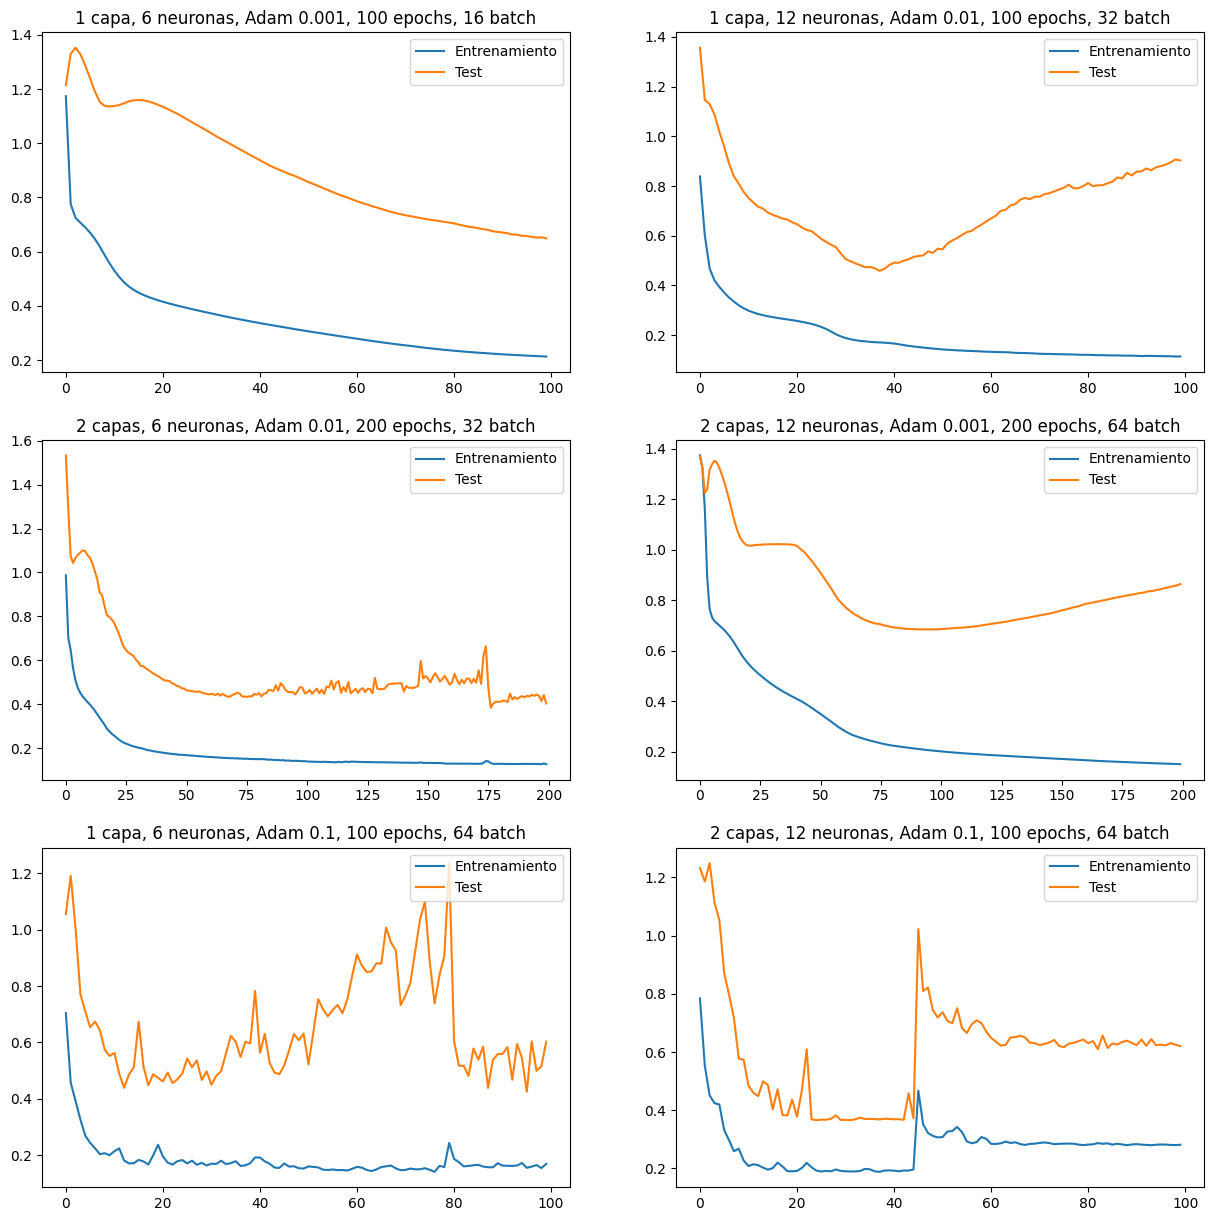

In [7]:
# Formamos una malla de 2 columnas de gráficos (cada una con la mitad de las configuraciones)
fig, ejes = plt.subplots(len(configuraciones)//2, 2, figsize=(15, 15))
fila = 0
columna = 0
for titulo in historiales:
  ejes[fila, columna].set_title(titulo)
  ejes[fila, columna].plot(historiales[titulo].history['loss'])
  ejes[fila, columna].plot(historiales[titulo].history['val_loss'])
  ejes[fila, columna].legend(['Entrenamiento', 'Test'], loc = 'upper right')
  if columna < 1:
    columna += 1
  else:
    columna = 0
    fila += 1

# Ejercicio propuesto

Sobre lo desarrollado hasta ahora, se proponen los siguientes pasos:

En primer lugar elimina del listado de configuraciones las 4 peores configuraciones, y cámbialas por estas otras 4:

* 2 capas de 6 neuronas, optimizador RMSProp con lr=0.01, 100 epochs, batch=32 y Dropout de 0.2 entre cada capa
* 3 capas de 6 neuronas, optimizador RMSProp con lr=0.05, 100 epochs, batch=64
* 2 capas de 12 neuronas, optimizador SGD con lr=0.01, 100 epochs, batch=16
* 2 capas de 6 neuronas, optimizador SGD con lr=0.005, 200 epochs, batch=64, y Dropout de 0.3 entre cada capa

Deberás adaptar el bucle de prueba de modelos para incluir nuevos optimizadores, y la posibilidad de definir capas de Dropout entre cada par de capas

Muestra de nuevo los gráficos y resultados de entrenamientos para determinar cuál es la mejor opción.